In [58]:
import os
import pandas as pd
import numpy as np
import re
import nltk

from collections import Counter

from sklearn import metrics

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords


from sentence_transformers import SentenceTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


import pandas as pd
import numpy as np
from numpy.random import RandomState
rng = RandomState()
df = pd.read_csv("data/fake.csv")
df = df[df.language == 'english']

print(df['type'].value_counts())


bs            10900
bias            443
conspiracy      430
hate            243
satire          146
state           120
junksci         102
fake             19
Name: type, dtype: int64


In [5]:
def getCleanData(df, force=False):
    # NOTICE: This takes several mins to run due to fillna
    
    print('Getting cleaned data')
    if not os.path.exists("caches/cleaned.csv") or force:
        print("start the cleaning process")

        cfd = pd.DataFrame()

        print("Fill missing values")
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        df.select_dtypes(include=numerics).fillna(df.mean())
        stop = stopwords.words('english')

        df['title_wo_stopwords'] = df['title'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))
        df['author_wo_stopwords'] = df['author'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))
        df['text_wo_stopwords'] = df['text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))
        df['titles_word_len'] = df.apply(lambda row: len(nltk.word_tokenize(row['title_wo_stopwords'])), axis=1)
        df['author_word_len'] = df.apply(lambda row: len(nltk.word_tokenize(row['author_wo_stopwords'])), axis=1)
        df['text_word_len'] = df.apply(lambda row: len(nltk.word_tokenize(row['text_wo_stopwords'])), axis=1)

        cfd['ord_in_thread'] = df['ord_in_thread']
        cfd['spam_score'] = df['spam_score']
        cfd['replies_count'] = df['replies_count']
        cfd['participants_count'] = df['participants_count']
        cfd['likes'] = df['likes']
        cfd['comments'] = df['comments']
        cfd['shares'] = df['shares']
        cfd['language'] = df['language'].map(lambda x: list(df['language'].unique()).index(x))
        cfd['country'] = df['country'].map(lambda x: list(df['country'].unique()).index(x))

        cfd['titles_word_len'] = df['titles_word_len']
        cfd['author_word_len'] = df['author_word_len']
        cfd['text_word_len'] = df['text_word_len']
        cfd['title_wo_stopwords'] = df['title_wo_stopwords']
        cfd['author_wo_stopwords'] = df['author_wo_stopwords']
        cfd['text_wo_stopwords'] = df['text_wo_stopwords']
        cfd['title'] = df['title']
        cfd['author'] = df['author']
        cfd['text'] = df['text']
        
        cfd['domain_rank'] = df['domain_rank'].fillna(0)
        cfd['site_url_length'] = df['site_url'].map(lambda x: len(str(x)))
        cfd['img_url_length'] = df['main_img_url'].map(lambda x: len(str(x)))
        cfd['wordpress'] = df['main_img_url'].map(lambda x: 1 if str(x).find('wp-content') >= 0 else 0)
        cfd['cloudfront'] = df['main_img_url'].map(lambda x: 1 if str(x).find('cloudfront') >= 0 else 0)
        cfd['img_query'] = df['main_img_url'].map(lambda x: 1 if str(x).find('?') >= 0 else 0)
        cfd['target'] = df['type'].map(lambda x: 1 if x == 'bs' else 0)

#         print(cfd.head(100))
        cfd.to_csv("caches/cleaned.csv")
    else:
        print('cleaned.csv exsists, pull from cache')
    
    print('returning')
    return pd.read_csv("caches/cleaned.csv")

In [6]:
cleandf = getCleanData(df, force=False)
cleandf.rename(columns = {'Unnamed: 0':'id'}, inplace = True)

print(cleandf['target'].value_counts())

Getting cleaned data
cleaned.csv exsists, pull from cache
returning
1    10900
0     1503
Name: target, dtype: int64


In [7]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Input: dataframe and field name
# Output: dataframe
# Description: Inplace adds a countVector field for the passed field
def vectorize(df, field, vecType):
    # list of text documents
    text = df[ field ].values.astype('U')
    # text = ["The quick brown fox jumped over the lazy dog.", "the dog", "the fox", " dog runs"]
    # create the transform
    if vecType == 'count_vector':
        vectorizer = CountVectorizer()
    elif vecType == 'tfidf':
        vectorizer = TfidfVectorizer(stop_words='english')
    else:
        raise Exception("Type options: count_vector or tfifd") 

    # tokenize and build vocab
    vectorizer.fit(text)
    # summarize
    # print(vectorizer.vocabulary_)
    # print(vectorizer.get_feature_names())

    # encode document
    vector = vectorizer.transform(text)

#     name = field+"_"+vecType
    name = field

    print("add new column ", name)

    print(vector.toarray().shape)
    
    df[ name ] = ''
    
    df[ name ] = vector.toarray()

    return df
    # feature_names = np.array(vectorizer.get_feature_names())

    # summarize encoded vector
    # print(vector.shape)
    # print(type(vector))


    # max_val = vector.max(axis=0).toarray().ravel()
    # # sort weights from smallest to biggest and extract their indices
    # max_val_sorted = max_val.argsort()

    # print(max_val_sorted)

    # print(max_val_sorted[:100])

    # print(feature_names[5748])

    # print("Features with lowest count:\n{}".format(feature_names[max_val_sorted[:100]]))
    # print("\nFeatures with highest count: \n{}".format(feature_names[max_val_sorted[-100:]]))




In [8]:
print('before')
print(cleandf.columns)
print(cleandf.describe())


vectorize(cleandf, 'title', 'tfidf')
vectorize(cleandf, 'title_wo_stopwords', 'tfidf')

vectorize(cleandf, 'author', 'tfidf')
vectorize(cleandf, 'author_wo_stopwords', 'tfidf')

vectorize(cleandf, 'text', 'tfidf')
vectorize(cleandf, 'text_wo_stopwords', 'tfidf')

# TODO: Cache this


# vectorize(cleandf, 'title', 'count_vector')
# vectorize(cleandf, 'title_wo_stopwords', 'count_vector')

# vectorize(cleandf, 'author', 'count_vector')
# vectorize(cleandf, 'author_wo_stopwords', 'count_vector')

# vectorize(cleandf, 'text', 'count_vector')
# vectorize(cleandf, 'text_wo_stopwords', 'count_vector')

print('after')
print(cleandf.columns)
print(cleandf.describe())



before
Index(['id', 'ord_in_thread', 'spam_score', 'replies_count',
       'participants_count', 'likes', 'comments', 'shares', 'language',
       'country', 'titles_word_len', 'author_word_len', 'text_word_len',
       'title_wo_stopwords', 'author_wo_stopwords', 'text_wo_stopwords',
       'title', 'author', 'text', 'domain_rank', 'site_url_length',
       'img_url_length', 'wordpress', 'cloudfront', 'img_query', 'target'],
      dtype='object')
                 id  ord_in_thread    spam_score  replies_count  \
count  12403.000000   12403.000000  12403.000000   12403.000000   
mean    6502.500847       0.934371      0.024484       1.449649   
std     3774.743448       6.637846      0.120583       9.881279   
min        0.000000       0.000000      0.000000       0.000000   
25%     3287.500000       0.000000      0.000000       0.000000   
50%     6477.000000       0.000000      0.000000       0.000000   
75%     9803.500000       0.000000      0.000000       0.000000   
max    12998

In [9]:
def split_x_y(df, target):
    try:
        y = df[ target ]
        X = df.drop(target, axis=1)
    except Exception as e:
        print('Error split_x_y')
        print (str(e))
    return X, y

X, y = split_x_y(cleandf, 'target')



In [10]:
# Under sample bc the dataset is wildly skewed

from imblearn.under_sampling import RandomUnderSampler

def resample(X, y):
    print('Original dataset shape %s' % Counter(y))

    under = RandomUnderSampler(sampling_strategy={1: 1503, 0: 1503})

    X_under_sample, y_under_sample = under.fit_resample(X, y)

    print('Resampled dataset shape %s' % Counter(y_under_sample))
    
    return X_under_sample, y_under_sample

X, y = resample(X, y)


Original dataset shape Counter({1: 10900, 0: 1503})
Resampled dataset shape Counter({0: 1503, 1: 1503})


In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn import utils
from sklearn.feature_selection import chi2

def select_k_best_features(X, y, k=10):
    try:
#         X=df.drop(targetVariable,axis=1)
#         y=df[targetVariable]

#         lab_enc = preprocessing.LabelEncoder()
#         training_scores_encoded = lab_enc.fit_transform(y)

#         utils.multiclass.type_of_target(y)
#         utils.multiclass.type_of_target(training_scores_encoded.astype('int'))
#         utils.multiclass.type_of_target(training_scores_encoded)
#         training_scores_encoded
#         #1-Univariete Selection

        #apply SelectKBest class to extract top 10 best features
        bestfeatures = SelectKBest(score_func=chi2, k='all')
        fit = bestfeatures.fit(X, y)
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(X.columns)
        #concat two dataframes for better visualization

        featureScores = pd.concat([dfcolumns, dfscores], axis=1)
        featureScores.columns = ['Specs','Score']  #naming the dataframe columns
        print('Top '+str(k)+' features')
        print(featureScores.nlargest(k,'Score'))
        return X, y
    except Exception as e:
        print("error Feature Selection")
        print (str(e))

X, y = select_k_best_features(X, y, 100)


Top 100 features
                 Specs         Score
19         domain_rank  3.847697e+06
0                   id  1.638694e+05
5                likes  4.714744e+04
7               shares  4.714744e+04
12       text_word_len  3.690538e+04
21      img_url_length  3.837243e+02
9              country  3.562130e+02
20     site_url_length  2.796117e+02
4   participants_count  3.813620e+01
24           img_query  3.488018e+01
23          cloudfront  3.200000e+01
11     author_word_len  2.465778e+01
22           wordpress  2.459294e+01
1        ord_in_thread  2.270995e+01
6             comments  1.207143e+01
10     titles_word_len  6.331122e+00
2           spam_score  2.002109e+00
18                text  5.991575e-01
15   text_wo_stopwords  5.990592e-01
3        replies_count  2.801120e-01


In [12]:
# test_data = pd.DataFrame()

# test_data['titles_word_len'] = cleandf['titles_word_len']
# test_data['author_word_len'] = cleandf['author_word_len']
# test_data['text_word_len'] = cleandf['text_word_len']
# test_data['title_wo_stopwords'] = cleandf['title_wo_stopwords']
# test_data['author_wo_stopwords'] = cleandf['author_wo_stopwords']
# test_data['text_wo_stopwords'] = cleandf['text_wo_stopwords']
# test_data['site_url_length'] = cleandf['site_url_length']
# test_data['img_url_length'] = cleandf['img_url_length']



# y = cleandf[ "target" ]

# print(cleandf)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# print(X_train)
# print(X_test)
# print(Y_train.describe())
# print(Y_test)



In [13]:
# print('Train sentance embeddings')

# model = SentenceTransformer('bert-base-nli-mean-tokens')

# if not os.path.exists("X_train_under_embedds.npy"):
#     print("start build embedding training models")
#     X_trainL = X_train_under.values.tolist()
#     list_of_string = [''.join(str(element)) for element in X_trainL]
#     X_train_under_embedds = model.encode(list_of_string)
#     np.save('X_train_under_embedds.npy', X_train_under_embedds)
#     print("end build embedding training models")
# else:
#     X_train_under_embedds = np.load('X_train_under_embedds.npy')
    
# print(len(X_train_under_embedds))

# if not os.path.exists("X_test_embedds.npy"):
#     print("start build embedding testing models")
#     X_testL = X_test.values.tolist()
#     list_of_stringTest = [''.join(str(element)) for element in X_testL]
#     X_test_embedds = model.encode(list_of_stringTest)
#     print("end build embedding testing models")
#     np.save('X_test_embedds.npy', X_test_embedds)
# else:
#     X_test_embedds = np.load('X_test_embedds.npy')

# print(len(X_test_embedds))

In [14]:
# print(X_train_under)
# print(X_train_under_embedds)

In [65]:
def performance_info(classifier, Y_test, pred, name=False):
    if name == 'linear_regression':
        return
    
    score = metrics.accuracy_score(Y_test, pred,)
    print("accuracy:   %0.3f" % score)

    conf_mat_gnb = metrics.confusion_matrix(Y_test, pred)
#     print(conf_mat_gnb)

    disp = metrics.plot_confusion_matrix(classifier, X_test, y_test,
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title(name)

    print(name)
    print(disp.confusion_matrix)


    print(metrics.classification_report(Y_test, pred, labels=np.unique(pred)))

In [56]:
import pickle

def build_model(model, X_train, y_train, X_test, y_test, save=False, name='test-save'):
    print('Building model '+name)
    print('Save '+str(save))
    
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    print(y_test.value_counts())
    
    performance_info(model, y_test, pred, name)
    
#     TODO: handle for save true but no or invalid name
    filename = 'models/'+name+'.pkl'
    
    pickle.dump(model, open(filename, 'wb'))
    
    print('Built model '+name)
    print("".join(["="]*50))
    return

# rf = RandomForestClassifier(max_depth = 100, min_samples_split=2, n_estimators = 500, random_state = 1)
# build_model(rf, X_train, y_train, True)

In [43]:
# Set up modeling functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

def random_forest(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Random Forest'
    print('Running '+name)
    try:
#         cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        random_forest = RandomForestClassifier(max_depth = 100, min_samples_split=2, n_estimators = 500, random_state = 1)
        results_randomforest = cross_val_score(random_forest, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_randomforest.mean())

        if build_model_ind:
            build_model(random_forest, X_train, y_train, X_test, y_test, True, name.replace(" ", "_").lower())

        return results_randomforest, random_forest
    except Exception as e:
        print('Error '+name)
        print (str(e))


from sklearn.naive_bayes import GaussianNB

def gaussian_naive_bayes(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
# def gaussian_naive_bayes(X, y, X_train=False, y_train=False):
    name = 'Gaussian Naive Bayes'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        gaussian = GaussianNB()
        results_gaussian = cross_val_score(gaussian, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_gaussian.mean())
        
        if build_model_ind:
            build_model(gaussian, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_gaussian, gaussian
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from sklearn.svm import SVC

def support_vector_machines(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Support Vector Machines'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
#         svc = SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma=1, kernel='linear', max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.001, verbose=False)
        svc = SVC(kernel='rbf', gamma='auto')
        results_svc = cross_val_score(svc, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_svc.mean())

        if build_model_ind:
            build_model(svc, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_svc, svc
    except Exception as e:
        print('Error '+name)
        print (str(e))

from sklearn.linear_model import LinearRegression

def linear_regression(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Linear Regression'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        lin_reg= LinearRegression()
        results_linreg= cross_val_score(lin_reg, X, y, cv=cv)
        print(name+' estimate accuracy',results_linreg.mean())

        if build_model_ind:
            build_model(lin_reg, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_linreg, lin_reg
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from sklearn.linear_model import LogisticRegression

def logistic_regression(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Logistic Regression'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
        results_logreg = cross_val_score(logreg, X, y, cv=cv,scoring='accuracy')
        print(name+' estimate accuracy',results_logreg.mean())

        if build_model_ind:
            build_model(logreg, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_logreg, logreg
    except Exception as e:
        print('Error '+name)
        print (str(e))

from sklearn.neighbors import KNeighborsClassifier

def KNN(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'KNN'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        knn = KNeighborsClassifier(n_neighbors = 3)
        results_knn = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_knn.mean())

        if build_model_ind:
            build_model(knn, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_knn, knn
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from sklearn.linear_model import Perceptron

def perceptron(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Perceprton'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        perceptron = Perceptron(max_iter=1000, tol=1e-3)
        results_perceptron = cross_val_score(perceptron, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_perceptron.mean())

        if build_model_ind:
            build_model(perceptron, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_perceptron, perceptron
    except Exception as e:
        print('Error '+name)
        print (str(e))

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis        

def linear_discriminant_analysis(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Linear Discriminant Analysis'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        clf = LinearDiscriminantAnalysis()
        results_clf = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_clf.mean())

        if build_model_ind:
            build_model(clf, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_clf, clf
    except Exception as e:
        print('Error '+name)
        print (str(e))

from sklearn.ensemble import AdaBoostClassifier      

def ada_boost_classifier(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Ada Boost Classifier'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        AB = AdaBoostClassifier()
        results_AB = cross_val_score(AB, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_AB.mean())

        if build_model_ind:
            build_model(AB, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_AB, AB
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from sklearn.ensemble import GradientBoostingClassifier        

def gradient_boosting_classifier(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'Gradient Boosting Classifier'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        GBC = GradientBoostingClassifier()
        results_GBC = cross_val_score(GBC, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_GBC.mean())

        if build_model_ind:
            build_model(GBC, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_GBC, GBC
    except Exception as e:
        print('Error '+name)
        print (str(e))
        
from xgboost.sklearn import XGBClassifier

def XGB_classifier(X, y, X_train=False, y_train=False, X_test=False, y_test=False, build_model_ind=False, save_model=False):
    name = 'XGBoost Classifier'
    print('Running '+name)
    try:
        cv = KFold(n_splits=10, random_state=42, shuffle=True)
        xgbs = XGBClassifier(objective="binary:logistic", random_state=42)
        results_xgbs = cross_val_score(xgbs, X, y, cv=cv, scoring='accuracy')
        print(name+' estimate accuracy',results_xgbs.mean())

        if build_model_ind:
            build_model(xgbs, X_train, y_train, X_test, y_test, save_model, name.replace(" ", "_").lower())

        return results_xgbs, xgbs
    except Exception as e:
        print('Error '+name)
        print (str(e))

Run classifications
Running Random Forest
Random Forest estimate accuracy 0.9956766334440752
Building model random_forest
Save True
0    388
1    364
Name: target, dtype: int64
accuracy:   0.992
random_forest
[[384   4]
 [  2 362]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       388
           1       0.99      0.99      0.99       364

    accuracy                           0.99       752
   macro avg       0.99      0.99      0.99       752
weighted avg       0.99      0.99      0.99       752

Built model random_forest
Running Gaussian Naive Bayes
Gaussian Naive Bayes estimate accuracy 0.6743023255813954
Building model gaussian_naive_bayes
Save True
0    388
1    364
Name: target, dtype: int64
accuracy:   0.686
gaussian_naive_bayes
[[279 109]
 [127 237]]
              precision    recall  f1-score   support

           0       0.69      0.72      0.70       388
           1       0.68      0.65      0.67       364

    accurac

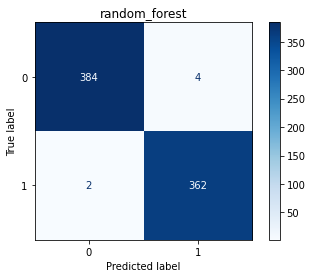

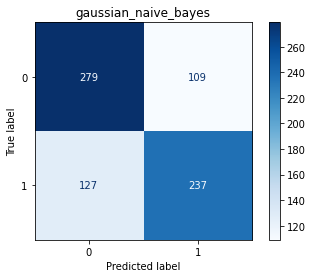

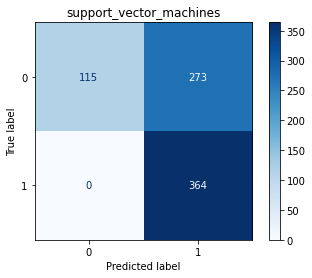

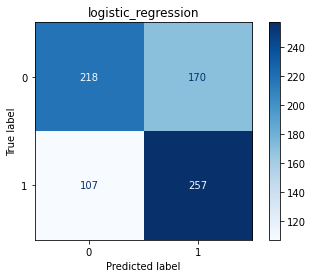

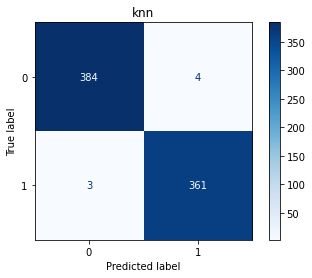

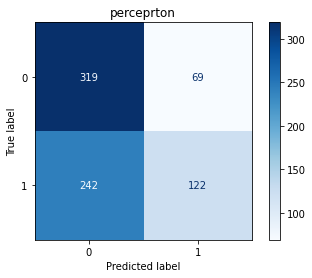

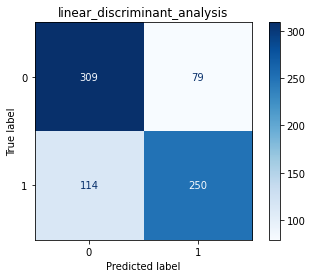

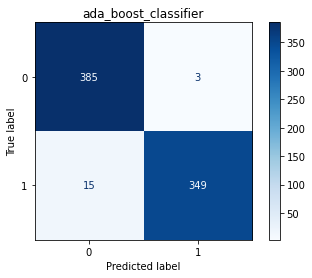

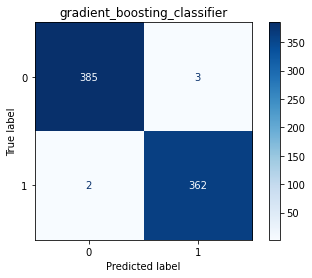

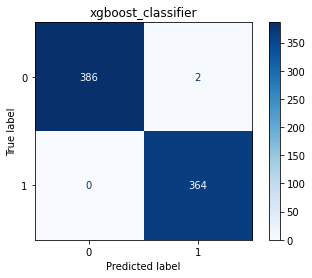

In [69]:
print('Run classifications')

results_random_forest, cl_random_forest = random_forest(X, y, X_train, y_train, X_test, y_test, True, True)
results_gaussian_naive_bayes, cl_gaussian_naive_bayes = gaussian_naive_bayes(X, y, X_train, y_train, X_test, y_test, True, True)
results_support_vector_machines, cl_support_vector_machines = support_vector_machines(X, y, X_train, y_train, X_test, y_test, True, True)
results_linear_regression, cl_linear_regression = linear_regression(X, y, X_train, y_train, X_test, y_test, True, True)
results_logistic_regression, cl_logistic_regression = logistic_regression(X, y, X_train, y_train, X_test, y_test, True, True)
results_KNN, cl_knn = KNN(X, y, X_train, y_train, X_test, y_test, True, True)
results_perceptron, cl_perceptron = perceptron(X, y, X_train, y_train, X_test, y_test, True, True)
results_linear_discriminant_analysis, cl_linear_discriminant_analysis = linear_discriminant_analysis(X, y, X_train, y_train, X_test, y_test, True, True)
results_ada_boost_classifier, cl_ada_boost_classifier = ada_boost_classifier(X, y, X_train, y_train, X_test, y_test, True, True)
results_gradient_boosting_classifier, cl_gradient_boosting_classifier = gradient_boosting_classifier(X, y, X_train, y_train, X_test, y_test, True, True)
results_XGB_classifier, cl_xgb_classifier = XGB_classifier(X, y, X_train, y_train, X_test, y_test, True, True)

# results_random_forest, cl_random_forest = random_forest(X, y)
# results_gaussian_naive_bayes, cl_gaussian_naive_bayes = gaussian_naive_bayes(X, y)
# results_support_vector_machines, cl_support_vector_machines = support_vector_machines(X, y)
# results_linear_regression, cl_linear_regression = linear_regression(X, y)
# results_logistic_regression, cl_logistic_regression = logistic_regression(X, y)
# results_KNN, cl_knn = KNN(X, y)
# results_perceptron, cl_perceptron = perceptron(X, y)
# results_linear_discriminant_analysis, cl_linear_discriminant_analysis = linear_discriminant_analysis(X, y)
# results_ada_boost_classifier, cl_ada_boost_classifier = ada_boost_classifier(X, y)
# results_gradient_boosting_classifier, cl_gradient_boosting_classifier = gradient_boosting_classifier(X, y)
# results_XGB_classifier, cl_xgb_classifier = XGB_classifier(X, y)

# initial
# Run classifications
# Running Random Forest
# Random Forest estimate accuracy 0.9604392317198528
# Running Gaussian Naive Bayes
# Gaussian Naive Bayes estimate accuracy 0.8711027568922306
# Running Support Vector Machines
# Support Vector Machines estimate accuracy 0.9013115738655394
# Running Linear Regression
# Linear Regression estimate accuracy 0.03227553195292534
# Running Logistic Regression
# Logistic Regression estimate accuracy 0.879164385618424
# Running KNN
# KNN estimate accuracy 0.8858305903006365
# Running Perceprton
# Perceprton estimate accuracy 0.7318553295681601
# Running Linear Discriminant Analysis
# Linear Discriminant Analysis estimate accuracy 0.879164385618424
# Running Ada Boost Classifier
# Ada Boost Classifier estimate accuracy 0.8795943776491921
# Running Gradient Boosting Classifier
# Gradient Boosting Classifier estimate accuracy 0.9253920515574651
# Running XGBoost Classifier
# XGBoost Classifier estimate accuracy 0.9594725292493906


# all features w/ y
# Run classifications
# Running Random Forest
# Random Forest estimate accuracy 0.9963410852713178
# Running Gaussian Naive Bayes
# Gaussian Naive Bayes estimate accuracy 0.6679811738648948
# Running Support Vector Machines
# Support Vector Machines estimate accuracy 0.6446987818383166
# Running Linear Regression
# Linear Regression estimate accuracy 0.2254357223925374
# Running Logistic Regression
# Logistic Regression estimate accuracy 0.6553643410852712
# Running KNN
# KNN estimate accuracy 0.9890243632336656
# Running Perceprton
# Perceprton estimate accuracy 0.5399379844961241
# Running Linear Discriminant Analysis
# Linear Discriminant Analysis estimate accuracy 0.7195526024363232
# Running Ada Boost Classifier
# Ada Boost Classifier estimate accuracy 0.9654031007751938
# Running Gradient Boosting Classifier
# Gradient Boosting Classifier estimate accuracy 0.9933466223698781
# Running XGBoost Classifier
# XGBoost Classifier estimate accuracy 0.9966733111849392



In [ ]:
# from sklearn.svm import SVC

# svc = SVC(kernel='rbf', gamma='auto')
# features_svm = X_train_under[['titles_word_len', 'author_word_len', 'text_word_len', 'title_wo_stopwords', 'author_wo_stopwords', 'text_wo_stopwords', 'site_url_length', 'img_url_length']].values

# pred_svm = svc.fit(features_svm, Y_train_under).predict(X_test)

# performance_info(Y_test, pred_svm)


In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# dtree = DecisionTreeClassifier()
# features_dtree = X_train_under[['titles_word_len', 'author_word_len', 'text_word_len', 'title_wo_stopwords', 'author_wo_stopwords', 'text_wo_stopwords', 'site_url_length', 'img_url_length']].values

# pred_dtree = dtree.fit(features_dtree, Y_train_under).predict(X_test)

# performance_info(Y_test, pred_dtree)


In [72]:
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

def voting_ensemble_classification(X, y, cl_random_forest, cl_gaussian_naive_bayes, cl_support_vector_machines, cl_linear_regression, cl_logistic_regression, cl_knn, cl_perceptron, cl_linear_discriminant_analysis, cl_ada_boost_classifier, cl_gradient_boosting_classifier, cl_xgb_classifier):
    # missing 
        # cl_linear_regression
    try:
        seed = 7
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

        # create the sub models
        estimators = []

        estimators.append(('logistic', cl_logistic_regression))
        estimators.append(('svc', cl_support_vector_machines))
        estimators.append(('knn', cl_knn))
        estimators.append(('gaussian', cl_gaussian_naive_bayes))
        estimators.append(('perceptron', cl_perceptron))
#         estimators.append(('linearsvc', linearsvc))
#         estimators.append(('sgd', sgd))
#         estimators.append(('decisiontree', decisiontree))
        estimators.append(('randomforest', cl_random_forest))
        estimators.append(('clf', cl_linear_discriminant_analysis))
        estimators.append(('AB', cl_ada_boost_classifier))
        
        estimators.append(('GBC', cl_gradient_boosting_classifier))
#         estimators.append(('ETC', ETC))
        estimators.append(('xgbs', cl_xgb_classifier))

        # create the ensemble model
        ensemble = VotingClassifier(estimators, voting='hard')
        results_ensemble = model_selection.cross_val_score(ensemble, X, y, cv=kfold)
        print(results_ensemble.mean())
        return results_ensemble
    except Exception as e:
        print("error ensemble")
        print (str(e))

voting_ensemble_classification(X, y, cl_random_forest, cl_gaussian_naive_bayes, cl_support_vector_machines, cl_linear_regression, cl_logistic_regression, cl_knn, cl_perceptron, cl_linear_discriminant_analysis, cl_ada_boost_classifier, cl_gradient_boosting_classifier, cl_xgb_classifier)

# 0.9860332225913622

# array([0.9833887 , 0.99003322, 0.98006645, 0.99335548, 0.98006645,
#        0.97342193, 0.98333333, 0.99333333, 0.99      , 0.99333333])

0.9866965669988927


array([0.98006645, 0.97674419, 0.99335548, 0.97342193, 0.99667774,
       0.99003322, 0.99      , 0.99333333, 0.98      , 0.99333333])

In [73]:
def model_evaluation(results_random_forest, results_gaussian_naive_bayes, results_support_vector_machines, results_linear_regression, results_logistic_regression, results_KNN, results_perceptron, results_linear_discriminant_analysis, results_ada_boost_classifier, results_gradient_boosting_classifier, results_XGB_classifier):
    try:
        #Model evaluation
        print("Model evaluation")
        models = pd.DataFrame({
        'Model': ['random forest', 'gaussian naive bayes', 'support vector machines', 'linear regression', 'logistic regression', 'KNN', 'perceptron', 'linear discriminant analysis', 'ada boost classifier', 'gradient boosting classifier', 'XGB classifie',],
        'Score': [
            results_random_forest.mean(),
            results_gaussian_naive_bayes.mean(),
            results_support_vector_machines.mean(),
            results_linear_regression.mean(),
            results_logistic_regression.mean(),
            results_KNN.mean(),
            results_perceptron.mean(),
            results_linear_discriminant_analysis.mean(),
            results_ada_boost_classifier.mean(),
            results_gradient_boosting_classifier.mean(),
            results_XGB_classifier.mean()
        ]})
        print(models.sort_values(by='Score', ascending=False))
        #Model score
    except Exception as e:
        print("error Model evaluation")
        print (str(e))

model_evaluation(results_random_forest, results_gaussian_naive_bayes, results_support_vector_machines, results_linear_regression, results_logistic_regression, results_KNN, results_perceptron, results_linear_discriminant_analysis, results_ada_boost_classifier, results_gradient_boosting_classifier, results_XGB_classifier)

# Model evaluation
#                            Model     Score
# 10                 XGB classifie  0.996673
# 0                  random forest  0.996341
# 9   gradient boosting classifier  0.993014
# 5                            KNN  0.989024
# 8           ada boost classifier  0.965403
# 7   linear discriminant analysis  0.719553
# 1           gaussian naive bayes  0.667981
# 4            logistic regression  0.655364
# 2        support vector machines  0.644699
# 6                     perceptron  0.539938
# 3              linear regression  0.225436


Model evaluation
                           Model     Score
10                 XGB classifie  0.996340
0                  random forest  0.995677
9   gradient boosting classifier  0.992678
5                            KNN  0.992016
8           ada boost classifier  0.969729
7   linear discriminant analysis  0.726209
4            logistic regression  0.683302
1           gaussian naive bayes  0.674302
2        support vector machines  0.649017
6                     perceptron  0.493681
3              linear regression  0.218384


In [16]:
# forest = RandomForestClassifier(max_depth = 100, min_samples_split=2, n_estimators = 500, random_state = 1)

# features_forest = X_train[['title_count_vector', 'title_wo_stopwords_count_vector', 'author_count_vector', 'author_wo_stopwords_count_vector', 'text_count_vector', 'text_wo_stopwords_count_vector']].values
# # score: 0.8791657708019781

# features_forest = X_train_under[['titles_word_len', 'author_word_len', 'text_word_len', 'title_wo_stopwords', 'author_wo_stopwords', 'text_wo_stopwords', 'site_url_length', 'img_url_length']].values
# score: 0.8797032896151366

# my_forest = forest.fit(X_train_under, Y_train_under)

# target = Y_train_under.values


# pred_forest = forest.predict(X_test)

# performance_info(Y_test, pred_forest)

# score = metrics.accuracy_score(Y_test, pred)
# print("accuracy:   %0.3f" % score)


# conf_mat = metrics.multilabel_confusion_matrix(Y_test, pred)
# print(conf_mat)


# print(metrics.classification_report(Y_test, pred, labels=np.unique(pred)))